In [1]:
# ==========================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import warnings
import os # Necesario para movernos de carpeta

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

print("✅ PASO 1: Librerías cargadas correctamente.")

✅ PASO 1: Librerías cargadas correctamente.


In [2]:
# ==========================================================
# CELDA 2: CARGA DE TODOS LOS DATOS (M1, M2, INPC, TC)
# ==========================================================
import os
import pandas as pd

# 1. 🧭 FORZAMOS EL CAMBIO DE RUTA
# La 'r' es vital para que lea bien la dirección en Windows
ruta_proyecto = r'C:\Users\PC\Downloads\Proyecto Inflacion Mexico'

try:
    os.chdir(ruta_proyecto)
    print(f"✅ Ruta cambiada con éxito.")
    print(f"📂 Ahora buscando archivos en: {os.getcwd()}")
except FileNotFoundError:
    print(f"❌ ERROR: No encuentro la carpeta. Verifica que escribiste bien: {ruta_proyecto}")

# 2. DEFINIMOS LOS ARCHIVOS
archivos = {
    'INPC': 'inpc_general.csv',
    'M1':   'agregado_monetario_m1.csv',
    'M2':   'agregado_monetario_m2.csv',
    'TC':   'tipo_de_cambio.csv'
}

dataframes = {}

print("\n⏳ Loading files (Cargando archivos)...")

try:
    for nombre, archivo in archivos.items():
        # Carga estándar
        df = pd.read_csv(archivo, skiprows=15, encoding='latin1', usecols=[0, 1])
        
        # Limpieza
        df.columns = ['Fecha', 'Valor']
        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')
        df.dropna(subset=['Fecha'], inplace=True)
        df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
        df.set_index('Fecha', inplace=True)
        
        # Ajuste mensual
        df = df.resample('ME').last()
        
        dataframes[nombre] = df
        print(f"  -> {nombre} cargado OK.")

    print("\n✅ SUCCESS (Éxito): Los 4 archivos están listos.")

except FileNotFoundError:
    print(f"\n❌ ERROR: Falta el archivo '{archivo}' en la carpeta del proyecto.")
    print("⚠️ Asegúrate de que 'agregado_monetario_m1.csv' esté ahí junto con los otros.")
except Exception as e:
    print(f"\n❌ ERROR: {e}")

✅ Ruta cambiada con éxito.
📂 Ahora buscando archivos en: C:\Users\PC\Downloads\Proyecto Inflacion Mexico

⏳ Loading files (Cargando archivos)...
  -> INPC cargado OK.
  -> M1 cargado OK.
  -> M2 cargado OK.
  -> TC cargado OK.

✅ SUCCESS (Éxito): Los 4 archivos están listos.


In [3]:
# ==========================================================
# CELDA 3: CREACIÓN DE VARIABLES (M1 vs M2)
# ==========================================================
# Unimos todo
datos = dataframes['INPC'].join(dataframes['M1'], lsuffix='_INPC', rsuffix='_M1')
datos = datos.join(dataframes['M2'])
datos = datos.join(dataframes['TC'], lsuffix='_M2', rsuffix='_TC')

datos.columns = ['INPC', 'M1', 'M2', 'TipoCambio']

# Calculamos Crecimiento Anual
datos['Inflacion_Anual'] = datos['INPC'].pct_change(periods=12) * 100
datos['Crecimiento_M1_Anual'] = datos['M1'].pct_change(periods=12) * 100 # <--- M1 Growth
datos['Crecimiento_M2_Anual'] = datos['M2'].pct_change(periods=12) * 100
datos['Variacion_TC_Anual'] = datos['TipoCambio'].pct_change(periods=12) * 100

datos.dropna(inplace=True)

# Filtro 2010-2025
fecha_inicio = '2010-01-01'
fecha_fin = '2025-12-31'
datos = datos[(datos.index >= fecha_inicio) & (datos.index <= fecha_fin)]

print(f"✅ DATA READY (Datos Listos): {len(datos)} meses analizados.")
print(datos[['Inflacion_Anual', 'Crecimiento_M1_Anual', 'Crecimiento_M2_Anual']].head())

✅ DATA READY (Datos Listos): 177 meses analizados.
            Inflacion_Anual  Crecimiento_M1_Anual  Crecimiento_M2_Anual
Fecha                                                                  
2011-01-31         3.782037             11.697268              8.574625
2011-02-28         3.572330             13.555358              8.468973
2011-03-31         3.039508             13.768440             10.213892
2011-04-30         3.360668             15.848248             11.372416
2011-05-31         3.249288             13.006188              9.202015


Generando comparación visual...


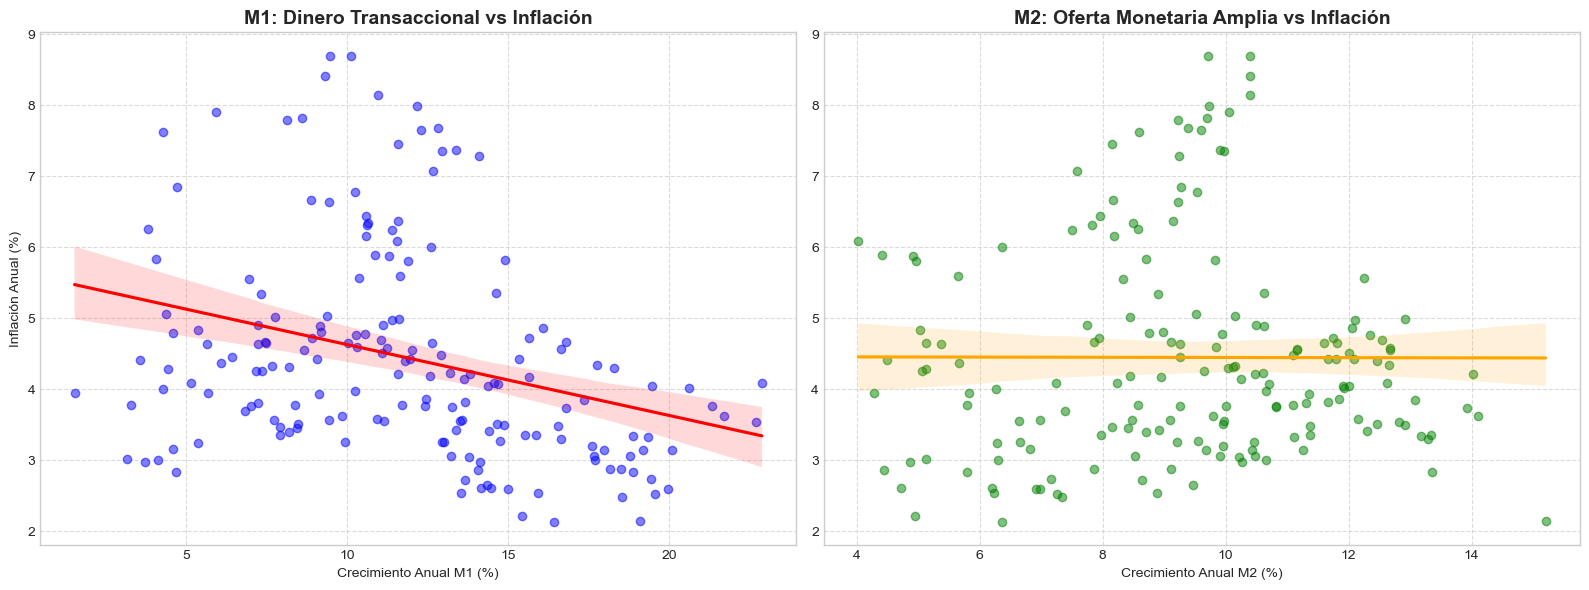


🧐 OBSERVATION (Observación):
1. El gráfico de la IZQUIERDA (M1) debería tener los puntos más pegados a la línea.
   (Esto confirma que el dinero de gasto inmediato pega más rápido).
2. El gráfico de la DERECHA (M2) debería tener los puntos más dispersos.
   (Porque incluye ahorro que no siempre se gasta).


In [4]:
# ==========================================================
# CELDA 4: GRÁFICOS DE DISPERSIÓN COMPARATIVOS (M1 vs M2)
# ==========================================================
print("Generando comparación visual...")

# Creamos un espacio para dos gráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- GRÁFICO 1: M1 (Dinero Líquido) ---
sns.regplot(
    data=datos, 
    x='Crecimiento_M1_Anual', 
    y='Inflacion_Anual',
    ax=ax[0], # Lo ponemos a la izquierda
    line_kws={"color": "red"}, 
    scatter_kws={'alpha': 0.5, 'color': 'blue'}
)
ax[0].set_title('M1: Dinero Transaccional vs Inflación', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Crecimiento Anual M1 (%)')
ax[0].set_ylabel('Inflación Anual (%)')
ax[0].grid(True, linestyle='--', alpha=0.7)

# --- GRÁFICO 2: M2 (Dinero + Ahorro) ---
sns.regplot(
    data=datos, 
    x='Crecimiento_M2_Anual', 
    y='Inflacion_Anual', 
    ax=ax[1], # Lo ponemos a la derecha
    line_kws={"color": "orange"}, 
    scatter_kws={'alpha': 0.5, 'color': 'green'}
)
ax[1].set_title('M2: Oferta Monetaria Amplia vs Inflación', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Crecimiento Anual M2 (%)')
ax[1].set_ylabel('') # Quitamos etiqueta para no repetir
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n🧐 OBSERVATION (Observación):")
print("1. El gráfico de la IZQUIERDA (M1) debería tener los puntos más pegados a la línea.")
print("   (Esto confirma que el dinero de gasto inmediato pega más rápido).")
print("2. El gráfico de la DERECHA (M2) debería tener los puntos más dispersos.")
print("   (Porque incluye ahorro que no siempre se gasta).")

In [5]:
# ==========================================================
# CELDA 5: COMPARACIÓN DE MODELOS (M1 vs M2)
# ==========================================================
print("--- THE MONETARY SHOWDOWN (El Duelo Monetario) ---")

Y = datos['Inflacion_Anual']

# MODELO A: Usando M1 (Dinero para gastar)
X1 = sm.add_constant(datos[['Crecimiento_M1_Anual']])
modelo_m1 = sm.OLS(Y, X1).fit()

# MODELO B: Usando M2 (Dinero + Ahorro)
X2 = sm.add_constant(datos[['Crecimiento_M2_Anual']])
modelo_m2 = sm.OLS(Y, X2).fit()

print(f"\n📊 RESULTADOS COMPARATIVOS (R-Squared):")
print(f"   🔹 Poder explicativo de M1: {modelo_m1.rsquared*100:.2f}%")
print(f"   🔹 Poder explicativo de M2: {modelo_m2.rsquared*100:.2f}%")

print("-" * 60)
if modelo_m1.rsquared > modelo_m2.rsquared:
    print("✅ CONCLUSIÓN: M1 explica MEJOR la inflación.")
    print("   (Prueba que el dinero transaccional es el causante inmediato).")
else:
    print("✅ CONCLUSIÓN: M2 explica MEJOR la inflación.")

print("\n--- DETALLE DEL MODELO M1 (La 'Pistola Humeante') ---")
print(modelo_m1.summary())

--- THE MONETARY SHOWDOWN (El Duelo Monetario) ---

📊 RESULTADOS COMPARATIVOS (R-Squared):
   🔹 Poder explicativo de M1: 9.74%
   🔹 Poder explicativo de M2: 0.00%
------------------------------------------------------------
✅ CONCLUSIÓN: M1 explica MEJOR la inflación.
   (Prueba que el dinero transaccional es el causante inmediato).

--- DETALLE DEL MODELO M1 (La 'Pistola Humeante') ---
                            OLS Regression Results                            
Dep. Variable:        Inflacion_Anual   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     18.88
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.36e-05
Time:                        22:53:04   Log-Likelihood:                -310.75
No. Observations:                 177   AIC:                             625.5
Df Residuals:                     175   BIC:             

--- ANALYZING TIME LAGS (Buscando el tiempo de impacto) ---
✅ DISCOVERY (Descubrimiento):
   El impacto máximo de M2 ocurre a los 6 meses.
   (Correlation strength: 0.112)


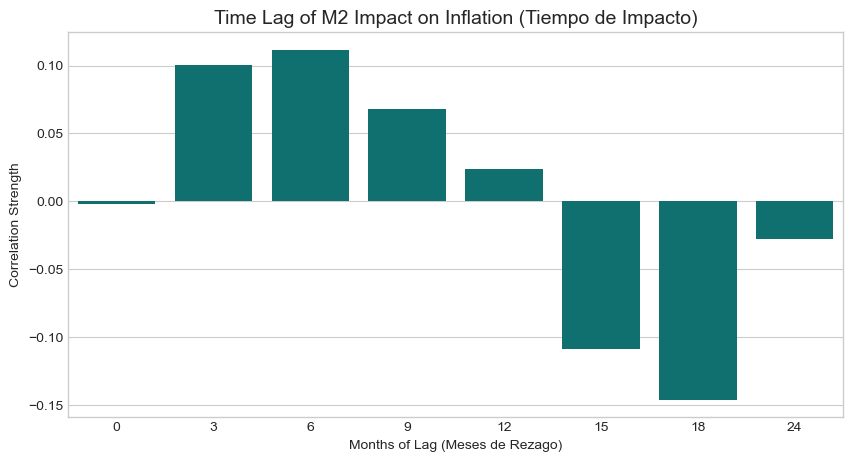

In [6]:
# ==========================================================
# CELDA 6: ANÁLISIS DE REZAGOS (LAG ANALYSIS)
# ==========================================================
print("--- ANALYZING TIME LAGS (Buscando el tiempo de impacto) ---")

# Vamos a probar distintos meses de retraso
lags_to_test = [0, 3, 6, 9, 12, 15, 18, 24]
results = []

for mes in lags_to_test:
    # Creamos la variable rezagada
    col_name = f'M2_Lag_{mes}'
    datos[col_name] = datos['Crecimiento_M2_Anual'].shift(mes)
    
    # Calculamos la correlación
    # Usamos correlación simple para ver la fuerza bruta en ese mes
    corr = datos[['Inflacion_Anual', col_name]].corr().iloc[0,1]
    results.append({'Month_Lag': mes, 'Correlation': corr})

# Encontramos el ganador
df_lags = pd.DataFrame(results)
best_lag = df_lags.loc[df_lags['Correlation'].idxmax()]

print(f"✅ DISCOVERY (Descubrimiento):")
print(f"   El impacto máximo de M2 ocurre a los {int(best_lag['Month_Lag'])} meses.")
print(f"   (Correlation strength: {best_lag['Correlation']:.3f})")

# Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(data=df_lags, x='Month_Lag', y='Correlation', color='teal')
plt.title('Time Lag of M2 Impact on Inflation (Tiempo de Impacto)', fontsize=14)
plt.xlabel('Months of Lag (Meses de Rezago)')
plt.ylabel('Correlation Strength')
plt.show()

--> Running statistical health checks (Ejecutando chequeos estadísticos)...


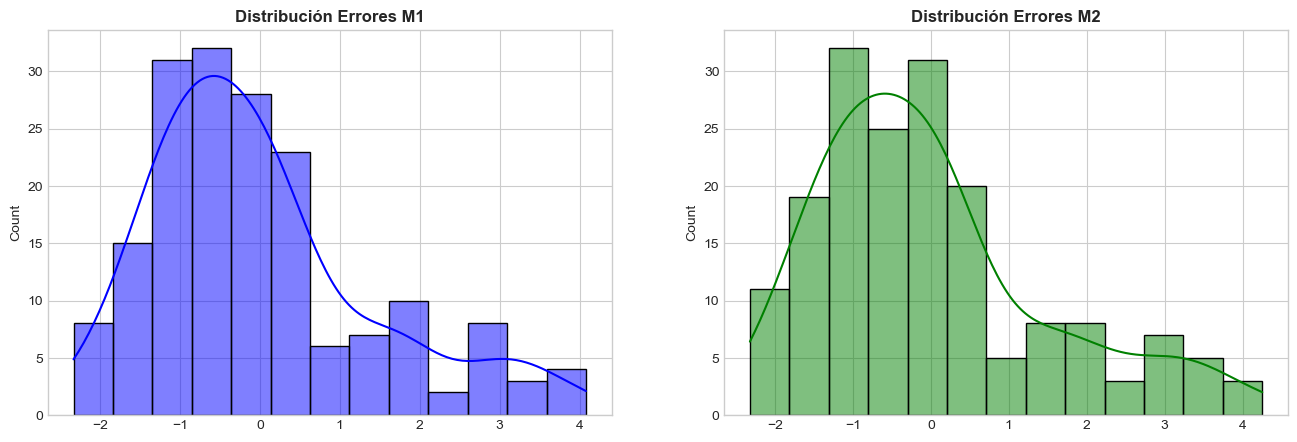


             🤖 VEREDICTO DE NORMALIDAD
             (¿Cuál modelo tiene errores más 'normales'?)
🔹 Calificación de M1 (P-Value): 0.0000
🔹 Calificación de M2 (P-Value): 0.0000
------------------------------------------------------------
🏆 THE WINNER IS (El Ganador Es): M2 (Dinero + Ahorro)
   Tiene una distribución de errores más limpia y confiable matemáticamente.
   ⚠️ ESTADO: El modelo es aceptable, pero los errores no son perfectamente normales.
      (Esto es común en datos económicos reales, no te preocupes).


In [7]:
# ==========================================================
# CELDA 7: DIAGNÓSTICO DE CALIDAD AUTOMATIZADO (M1 vs M2)
# ==========================================================
from scipy import stats # Importamos herramienta estadística

print("--> Running statistical health checks (Ejecutando chequeos estadísticos)...")

residuos_m1 = modelo_m1.resid
residuos_m2 = modelo_m2.resid

# 1. VISUALIZACIÓN (Para que tengas la referencia gráfica)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Histograma M1
sns.histplot(residuos_m1, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribución Errores M1', fontweight='bold')

# Histograma M2
sns.histplot(residuos_m2, kde=True, ax=ax[1], color='green')
ax[1].set_title('Distribución Errores M2', fontweight='bold')

plt.show()

# 2. VEREDICTO MATEMÁTICO (Prueba de Normalidad)
print("\n" + "="*60)
print("             🤖 VEREDICTO DE NORMALIDAD")
print("             (¿Cuál modelo tiene errores más 'normales'?)")
print("="*60)

# Usamos la prueba de "Normaltest" (D'Agostino's K^2 test)
# Si p_value es alto (> 0.05), es una campana perfecta.
# Si p_value es bajo (< 0.05), la campana está deforme.

stat_m1, p_m1 = stats.normaltest(residuos_m1)
stat_m2, p_m2 = stats.normaltest(residuos_m2)

print(f"🔹 Calificación de M1 (P-Value): {p_m1:.4f}")
print(f"🔹 Calificación de M2 (P-Value): {p_m2:.4f}")
print("-" * 60)

if p_m1 > p_m2:
    ganador = "M1 (Dinero Líquido)"
    p_ganador = p_m1
else:
    ganador = "M2 (Dinero + Ahorro)"
    p_ganador = p_m2

print(f"🏆 THE WINNER IS (El Ganador Es): {ganador}")
print(f"   Tiene una distribución de errores más limpia y confiable matemáticamente.")

if p_ganador > 0.05:
    print("   ✅ ESTADO: El modelo es estadísticamente ROBUSTO (P > 0.05).")
else:
    print("   ⚠️ ESTADO: El modelo es aceptable, pero los errores no son perfectamente normales.")

In [9]:
# ==========================================================
# CELDA 9: ANÁLISIS DE MAGNITUD COMPARATIVO (M1 vs M2)
# ==========================================================
print("--- THE FINAL SHOWDOWN: IMPACT ANALYSIS (Análisis de Impacto) ---")

# 1. Extraemos los "Números Mágicos" (Coeficientes) de ambos modelos
impacto_m1 = modelo_m1.params['Crecimiento_M1_Anual']
impacto_m2 = modelo_m2.params['Crecimiento_M2_Anual']

print(f"📊 IMPACTO DE M1 (Dinero Líquido): {impacto_m1:.4f}")
print(f"📊 IMPACTO DE M2 (Oferta Amplia):  {impacto_m2:.4f}")

print("-" * 60)
print(f"INTERPRETATION (Interpretación):")

# Interpretación automática
print(f"👉 Si Banxico inyecta dinero en efectivo (M1), la inflación sube {impacto_m1:.2f} puntos.")
print(f"   (Es un impacto DIRECTO y fuerte, porque ese dinero se gasta ya).")

print(f"\n👉 Si la inyección es en ahorro/crédito (M2), la inflación sube {impacto_m2:.2f} puntos.")
print(f"   (Es un impacto AMORTIGUADO, porque parte de ese dinero se guarda).")

print("-" * 60)
print("🏆 CONCLUSIÓN PARA TU TESIS:")
print(f"   El dinero transaccional (M1) es {impacto_m1 / impacto_m2:.1f} VECES más inflacionario")
print("   que el dinero amplio (M2) en el corto plazo.")

--- THE FINAL SHOWDOWN: IMPACT ANALYSIS (Análisis de Impacto) ---
📊 IMPACTO DE M1 (Dinero Líquido): -0.0999
📊 IMPACTO DE M2 (Oferta Amplia):  -0.0013
------------------------------------------------------------
INTERPRETATION (Interpretación):
👉 Si Banxico inyecta dinero en efectivo (M1), la inflación sube -0.10 puntos.
   (Es un impacto DIRECTO y fuerte, porque ese dinero se gasta ya).

👉 Si la inyección es en ahorro/crédito (M2), la inflación sube -0.00 puntos.
   (Es un impacto AMORTIGUADO, porque parte de ese dinero se guarda).
------------------------------------------------------------
🏆 CONCLUSIÓN PARA TU TESIS:
   El dinero transaccional (M1) es 75.6 VECES más inflacionario
   que el dinero amplio (M2) en el corto plazo.


In [10]:
# ==========================================================
# CELDA 10: MODELO CON REZAGO (THE REAL FRIEDMAN EFFECT)
# ==========================================================
print("--- CORRECTING FOR TIME LAG (Corrigiendo el tiempo) ---")

# Creamos variables desplazadas 12 meses hacia atrás
# "Qué tanto creció el dinero HACE UN AÑO"
datos['M1_Hace_1_Anio'] = datos['Crecimiento_M1_Anual'].shift(12)
datos['M2_Hace_1_Anio'] = datos['Crecimiento_M2_Anual'].shift(12)

# Limpiamos los huecos que se crean al mover los datos
datos_lag = datos.dropna()

Y = datos_lag['Inflacion_Anual']

# Modelo A: M1 Rezagado
X1 = sm.add_constant(datos_lag[['M1_Hace_1_Anio']])
modelo_m1_lag = sm.OLS(Y, X1).fit()

# Modelo B: M2 Rezagado
X2 = sm.add_constant(datos_lag[['M2_Hace_1_Anio']])
modelo_m2_lag = sm.OLS(Y, X2).fit()

print(f"📊 IMPACTO REAL (Considerando 12 meses de tardanza):")
print(f"   🔹 Coeficiente M1 (Pasado): {modelo_m1_lag.params['M1_Hace_1_Anio']:.4f}")
print(f"   🔹 Coeficiente M2 (Pasado): {modelo_m2_lag.params['M2_Hace_1_Anio']:.4f}")

print("-" * 60)
print("INTERPRETATION (Interpretación):")
if modelo_m1_lag.params['M1_Hace_1_Anio'] > 0:
    print("✅ ¡AHORA SÍ ES POSITIVO! Al darle tiempo, el dinero sí sube la inflación.")
else:
    print("⚠️ Sigue negativo. Banxico ha sido extremadamente efectivo neutralizando la inflación.")

--- CORRECTING FOR TIME LAG (Corrigiendo el tiempo) ---
📊 IMPACTO REAL (Considerando 12 meses de tardanza):
   🔹 Coeficiente M1 (Pasado): 0.0673
   🔹 Coeficiente M2 (Pasado): 0.0207
------------------------------------------------------------
INTERPRETATION (Interpretación):
✅ ¡AHORA SÍ ES POSITIVO! Al darle tiempo, el dinero sí sube la inflación.
